In [1]:
import pandas as pd
import numpy as np
import sklearn

# EDA

In [ ]:
cells = pd.read_csv("TG_LASSO_GeneExpressionInput/TG_LASSO_GeneExpressionInput/gdsc_expr_postCB.csv",  index_col=0)

In [3]:
# Columns are cell lines are samples, so we flip it
cellsT = cells.T

In [4]:
print(cellsT.describe())

       ENSG00000000003  ENSG00000000419  ENSG00000000457  ENSG00000000460  \
count       979.000000       979.000000       979.000000       979.000000   
mean          5.616081         8.184602         3.240549         2.625700   
std           1.615159         0.578248         0.558842         0.617289   
min           2.478080         1.010429         2.060476         1.423062   
25%           4.988018         7.822825         2.857939         2.178742   
50%           6.137223         8.177196         3.145284         2.509144   
75%           6.704101         8.544412         3.497180         2.980124   
max           9.071790        10.089456         5.876035         5.036346   

       ENSG00000000938  ENSG00000000971  ENSG00000001036  ENSG00000001084  \
count       979.000000       979.000000       979.000000       979.000000   
mean          2.826448         3.688519         6.152474         4.771073   
std           1.086662         1.719458         1.469351         1.095915  

# 1 Dimensionality reduction

## a)

Let’s start by visualizing the data using dimensionality reduction methods. Use PCA, 
UMAP and t-SNE algorithms to map the samples onto a 2-D space for visualization 
(you do not need to implement these methods from scratch. You only need to find 
their implementation). 

### PCA

In [5]:
from sklearn.preprocessing import StandardScaler

print(cellsT.values)

[[2.50872946 8.96881371 4.4322308  ... 7.75863365 5.59888908 6.08164171]
 [7.03716409 9.03252603 2.93187717 ... 5.19903771 1.16430049 5.58163531]
 [2.57739711 8.56738133 2.56012163 ... 6.75267745 1.03652485 7.31234154]
 ...
 [6.75877915 7.13153445 2.93575276 ... 6.27909185 2.5516835  4.35594874]
 [7.31362289 8.14762082 3.58668577 ... 6.56430732 0.61677143 5.1263295 ]
 [4.85571109 8.34944175 2.80804644 ... 6.84318232 1.33661459 6.39444929]]


Standardizing the features

In [6]:
x = StandardScaler().fit_transform(cellsT.values)

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
drPCA = pca.fit_transform(cellsT.values)

In [8]:
print(drPCA.shape)

(979, 2)


### UMAP

In [9]:
import umap

In [10]:
reducer = umap.UMAP(n_components=2, random_state=789)
drUMAP = reducer.fit_transform(x)
print(drUMAP.shape)

(979, 2)


### t-SNE

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=32)
drTSNE = tsne.fit_transform(x)
print(drTSNE.shape)

(979, 2)


### Plot

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

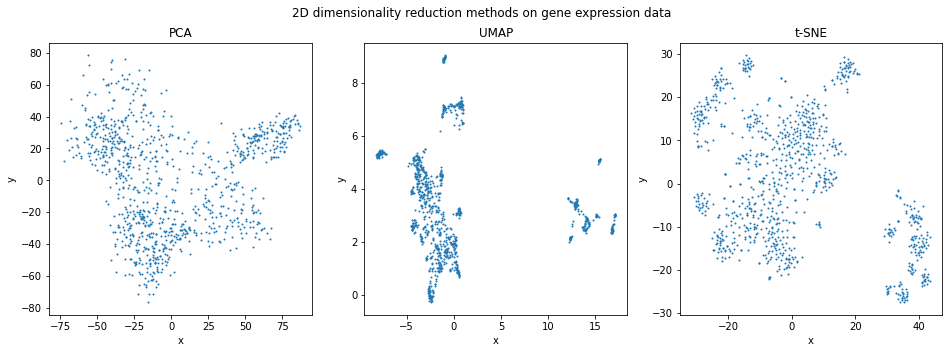

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('2D dimensionality reduction methods on gene expression data')

axs[0].scatter(drPCA[:,0], drPCA[:,1], s=1)
axs[0].set_title('PCA')
axs[1].scatter(drUMAP[:,0], drUMAP[:,1], s=1)
axs[1].set_title('UMAP')
axs[2].scatter(drTSNE[:,0], drTSNE[:,1], s=1)
axs[2].set_title('t-SNE')

for ax in axs.flat:
    ax.set(xlabel='x', ylabel='y')
    
plt.show()

# 2 Clustering

In [14]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [15]:
cells_kmeans = KMeans(n_clusters=3, random_state=42).fit(cellsT.values)
cells_AC = AgglomerativeClustering(n_clusters=3).fit(cellsT.values)

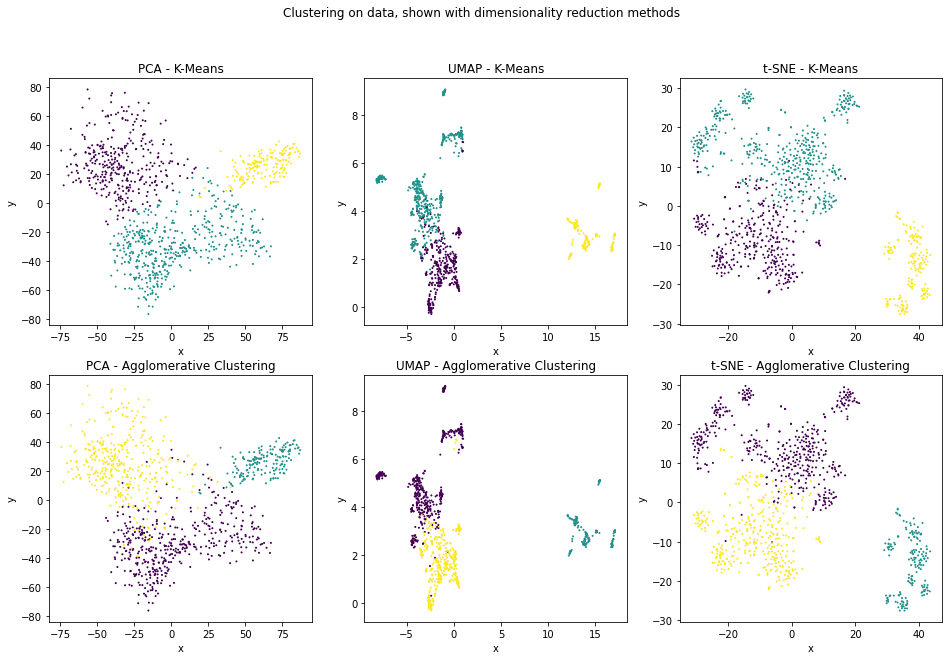

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Clustering on data, shown with dimensionality reduction methods')

# .labels_ labels 0,1,2, which are used to label the points with colours
axs[0][0].scatter(drPCA[:,0], drPCA[:,1], s=1, c=cells_kmeans.labels_)
axs[0][0].set_title('PCA - K-Means')
axs[0][1].scatter(drUMAP[:,0], drUMAP[:,1], s=1, c=cells_kmeans.labels_)
axs[0][1].set_title('UMAP - K-Means')
axs[0][2].scatter(drTSNE[:,0], drTSNE[:,1], s=1, c=cells_kmeans.labels_)
axs[0][2].set_title('t-SNE - K-Means')

axs[1][0].scatter(drPCA[:,0], drPCA[:,1], s=1, c=cells_AC.labels_)
axs[1][0].set_title('PCA - Agglomerative Clustering')
axs[1][1].scatter(drUMAP[:,0], drUMAP[:,1], s=1, c=cells_AC.labels_)
axs[1][1].set_title('UMAP - Agglomerative Clustering')
axs[1][2].scatter(drTSNE[:,0], drTSNE[:,1], s=1, c=cells_AC.labels_)
axs[1][2].set_title('t-SNE - Agglomerative Clustering')

for ax in axs.flat:
    ax.set(xlabel='x', ylabel='y')
    
plt.show()

In [17]:
# one hot encode labels - each column is which one it belongs to
cells_kmeans1h = pd.get_dummies(cells_kmeans.labels_)
cells_AC1h = pd.get_dummies(cells_AC.labels_)
print(cells_kmeans1h.shape, cells_kmeans1h.columns)
# columns are cluster labels

(979, 3) Int64Index([0, 1, 2], dtype='int64')


In [18]:
# produce jaccard index:
jaccs = np.zeros((3,3))

for y in cells_kmeans1h.columns:
    for x in cells_AC1h.columns:
        # rows are k-means, columns are Agglomerative Clustering
        # doing jaccard of each 1-hot encoded column by selecting columns (they are dataframes)
        jaccs[y,x] = sklearn.metrics.jaccard_score(cells_kmeans1h[y], cells_AC1h[x])

print(jaccs)

[[0.02193548 0.         0.86387435]
 [0.89166667 0.         0.04413619]
 [0.         1.         0.        ]]


In [19]:
cells_AC_cos = AgglomerativeClustering(n_clusters=3, linkage='average', affinity='cosine').fit(cellsT.values)
cells_AC_euc = AgglomerativeClustering(n_clusters=3, linkage='average', affinity='euclidean').fit(cellsT.values)

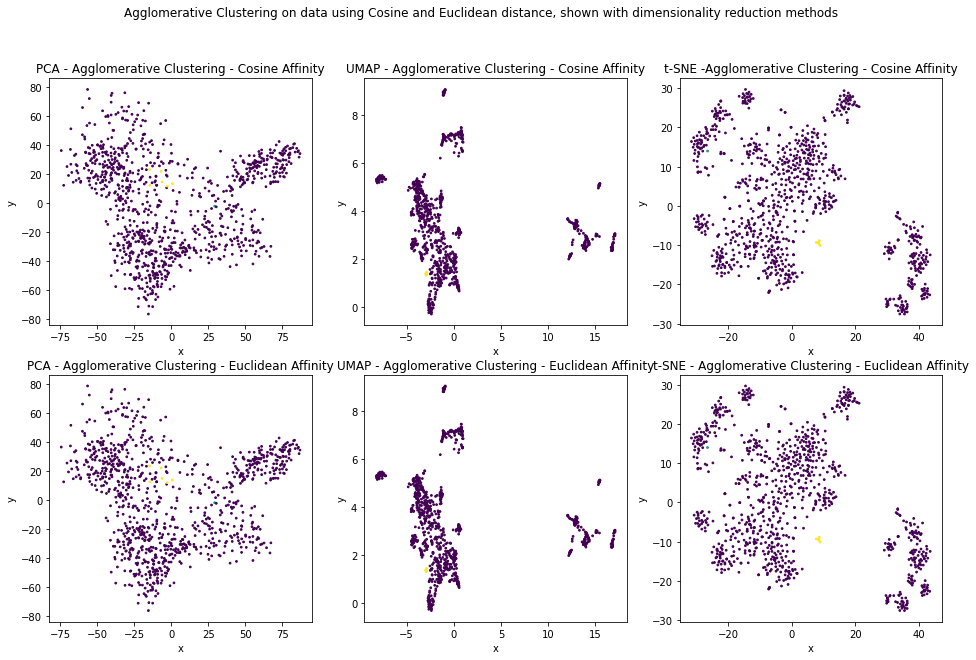

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Agglomerative Clustering on data using Cosine and Euclidean distance, shown with dimensionality reduction methods')

axs[0][0].scatter(drPCA[:,0], drPCA[:,1], s=3, c=cells_AC_cos.labels_)
axs[0][0].set_title('PCA - Agglomerative Clustering - Cosine Affinity')
axs[0][1].scatter(drUMAP[:,0], drUMAP[:,1], s=3, c=cells_AC_cos.labels_)
axs[0][1].set_title('UMAP - Agglomerative Clustering - Cosine Affinity')
axs[0][2].scatter(drTSNE[:,0], drTSNE[:,1], s=3, c=cells_AC_cos.labels_)
axs[0][2].set_title('t-SNE -Agglomerative Clustering - Cosine Affinity')

axs[1][0].scatter(drPCA[:,0], drPCA[:,1], s=3, c=cells_AC_euc.labels_)
axs[1][0].set_title('PCA - Agglomerative Clustering - Euclidean Affinity')
axs[1][1].scatter(drUMAP[:,0], drUMAP[:,1], s=3, c=cells_AC_euc.labels_)
axs[1][1].set_title('UMAP - Agglomerative Clustering - Euclidean Affinity')
axs[1][2].scatter(drTSNE[:,0], drTSNE[:,1], s=3, c=cells_AC_euc.labels_)
axs[1][2].set_title('t-SNE - Agglomerative Clustering - Euclidean Affinity')

for ax in axs.flat:
    ax.set(xlabel='x', ylabel='y')
    
plt.show()

In [21]:
# one hot encode labels
cells_AC_cos1h = pd.get_dummies(cells_AC_cos.labels_)
cells_AC_euc1h = pd.get_dummies(cells_AC_euc.labels_)
# columns are cluster labels

# produce jaccard index:
jaccs = np.zeros((3,3))

for y in cells_AC_euc1h.columns:
    for x in cells_AC_cos1h.columns:
        # rows are k-means, columns are Agglomerative Clustering
        # doing jaccard of each 1-hot encoded column by selecting columns (they are dataframes)
        jaccs[y,x] = sklearn.metrics.jaccard_score(cells_AC_euc1h[y], cells_AC_cos1h[x])

print(jaccs)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


# 3 Regression

## a)

In [22]:
# Transpose
drug_response = pd.read_csv("gdsc_dr.csv",  index_col=0).T

In [23]:
drug_response

,bicalutamide,bleomycin,cetuximab,cisplatin,dabrafenib,docetaxel,doxorubicin,erlotinib,etoposide,gefitinib,...,methotrexate,paclitaxel,sorafenib,sunitinib,tamoxifen,temozolomide,trametinib,veliparib,vinblastine,vinorelbine
906877,4.045834,3.222664,6.891379,2.105065,1.952287,-3.270194,-1.174680,3.637529,2.075121,0.199276,...,-3.325944,-2.877949,3.964843,2.600165,2.423150,6.172092,1.744467,4.400879,-4.844162,-4.964419
906798,4.211041,-1.211779,5.296735,0.796922,4.046885,-6.428108,-3.972152,NaN,0.178869,-0.174147,...,0.443583,NaN,NaN,NaN,3.595367,5.440697,-1.402534,2.351076,-5.371709,-4.831949
906872,4.049380,-0.256964,5.801584,2.761949,0.753324,-5.503124,-2.539475,2.620818,1.632566,1.906724,...,-1.551749,-3.011545,1.990258,5.200061,3.843958,3.824714,-3.954082,4.343947,-5.030570,-5.219549
906873,NaN,6.107328,NaN,2.579232,NaN,-6.688298,-0.563974,NaN,3.681456,1.597928,...,1.012463,NaN,NaN,NaN,4.125364,NaN,NaN,4.224974,-4.531903,-2.557654
906870,3.877443,-1.078430,6.445177,4.219197,1.309017,-2.251705,-1.839028,2.708165,1.192963,1.563724,...,0.748356,-4.272402,-3.194068,-2.906274,2.746303,5.411817,0.875101,3.967232,-1.001346,-3.684773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684052,4.237832,2.377093,6.387324,NaN,1.124854,NaN,-1.545769,NaN,0.894428,NaN,...,NaN,NaN,NaN,NaN,3.574546,5.604447,-0.078737,NaN,NaN,-4.842541
684057,4.483345,1.680966,6.393561,1.131967,2.190806,-6.737135,-0.158986,3.571787,2.345492,2.152026,...,-1.461471,0.096091,3.372302,3.237325,3.806994,5.904012,2.238231,3.346795,-5.313013,-3.565445
687807,5.578226,3.103060,6.371143,5.327995,4.692428,-1.661238,-0.874507,2.101461,6.128257,1.027900,...,0.128752,-0.296777,4.511586,4.770752,4.898312,6.404029,0.568076,4.122401,-2.175486,0.674024
684055,4.339973,0.297434,4.952125,NaN,1.751297,NaN,-2.935656,3.342826,-0.344598,NaN,...,NaN,-0.214086,2.108016,3.128074,3.689797,5.595628,0.859150,NaN,NaN,-4.037407


In [24]:
cellsT = cells.T

Clean out values for which there is no response for doxorubicin

In [25]:
# indices where doxorubicin has NaN
dox_notna = drug_response.doxorubicin.notna()

# select values
drug_response = drug_response.loc[dox_notna]
cellsT = cellsT.loc[dox_notna]

Create Lasso

In [26]:
from sklearn.linear_model import Lasso

# Set hyperparameters and inputs
X = cellsT.values
y = drug_response.doxorubicin.values

alphas = np.array([0.1, 0.3, 0.5, 0.7, 0.9])

In [27]:
# (number of params to test, number of weights/features)
coefs = np.empty((alphas.size, X.shape[1]))
for i, alpha in enumerate(alphas):
    clf = Lasso(alpha=alpha,
            fit_intercept=False, # no bias term in question
            selection='random',
            random_state=42,
            max_iter=100000)
    
    coefs[i] = clf.fit(X, y).coef_

num_coeffs = np.array([np.count_nonzero(coef) for coef in coefs])

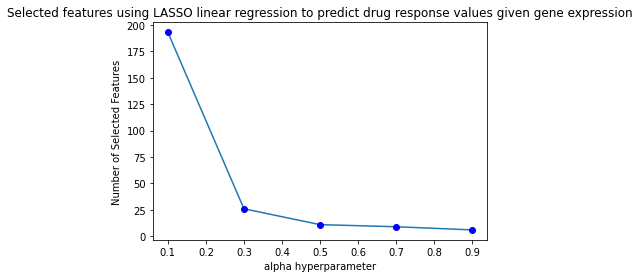

In [28]:
plt.plot(alphas, num_coeffs)
plt.plot(alphas, num_coeffs, 'bo')
plt.xlabel('alpha hyperparameter')
plt.ylabel('Number of Selected Features')
plt.title('Selected features using LASSO linear regression to predict drug response values given gene expression')
plt.show()

## b)

In [29]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from statistics import mean

# spearmanr outputs (correlation, p-value); only want first one
spmn = lambda x, y: spearmanr(x,y)[0]

def nested_cv(X,
              y, 
              inner=3, 
              outer=4, 
              params={'alpha':alphas}, 
              scoring=mean_squared_error,
              biggerIsBetter=False,
              random_state_outer=42,
              random_state_inner=24):

    outer_folds = KFold(n_splits=outer, shuffle=True, random_state=random_state_outer)
    spmns = []
    mses = []
    results = []
    best_alphas = []
    
    # creating scorer for GridSearchCV to choose best model
    scorer = make_scorer(scoring, greater_is_better=biggerIsBetter)
    

    for i, (itrain, itest) in enumerate(outer_folds.split(X)):
        print(f'Outer loop {i}')
        
        
        Xtrain = X[itrain,:]
        Xtest = X[itest,:]

        ytrain = y[itrain]
        ytest = y[itest]

        inner_folds = KFold(n_splits=inner, shuffle=True, random_state=random_state_inner)                
            
        # GridSearchCV performs CV using 'cv' folds to evaluate based on 'scoring' for each hyperparameter
        # in the parameter space. Refit=True fits a best estimator using best hyperparameter after CV.
        grid_search = GridSearchCV(clf, params, scoring=scorer, cv=inner_folds, refit=True)

        inner_cv = grid_search.fit(Xtrain, ytrain)
        
        best_alphas.append(inner_cv.best_params_['alpha'])
        results.append(inner_cv.cv_results_)
        spmns.append(spmn(ytest, inner_cv.predict(Xtest)))
        mses.append(mean_squared_error(ytest, inner_cv.predict(Xtest)))

        
        print(f'Best Alpha: {best_alphas[-1]}, Spearman: {spmns[-1]}, MSE: {mses[-1]}')
        
    print(f'Average Spearman: {mean(spmns)}')
    print(f'Average MSE: {mean(mses)}')
        
    return results, best_alphas, spmns, mses
        
        
    

In [30]:
# Use Spearman as criterion (is score and therefore bigger is better)
results_sp, best_alphas_sp, spmns_sp, mses_sp = nested_cv(X, y, scoring=spmn, biggerIsBetter=True)

Outer loop 0
Best Alpha: 0.3, Spearman: 0.2034605358641407, MSE: 2.904603050028453
Outer loop 1
Best Alpha: 0.5, Spearman: 0.15934553756394534, MSE: 2.904603534428294
Outer loop 2
Best Alpha: 0.1, Spearman: 0.2712755021373523, MSE: 2.6050956136040693
Outer loop 3
Best Alpha: 0.3, Spearman: 0.24698480137189002, MSE: 2.261122935952754
Average Spearman: 0.2202665942343321
Average MSE: 2.6688562835033927


In [31]:
# Use MSE as criterion (smaller is better)
results_mse, best_alphas_mse, spmns_mse, mses_mse = nested_cv(X, y, random_state_outer=13, random_state_inner=31)

Outer loop 0
Best Alpha: 0.3, Spearman: 0.21265859293240336, MSE: 2.7663882130848294
Outer loop 1
Best Alpha: 0.3, Spearman: 0.22661841962761825, MSE: 2.3792656733735496
Outer loop 2
Best Alpha: 0.3, Spearman: 0.35729314651505295, MSE: 2.459646360857652
Outer loop 3
Best Alpha: 0.3, Spearman: 0.2944496020951323, MSE: 2.7957827677076867
Average Spearman: 0.2727549402925517
Average MSE: 2.6002707537559293
